### Calculate global tropospheric burdens, CH4 lifetime and NH/SH air mass averaged tropospheric OH ratio

In [1]:
import datetime
import warnings
from pathlib import Path

import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
from scipy import stats

In [2]:
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import EXPERIMENTS, GASES
from util_mypaths import path_to_processed, path_to_raw, path_to_results
from util_plot_func import use_draft_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
register_matplotlib_converters()  # for tstamps
use_draft_style()

In [5]:
# Switches
trop_def = "chemical"  # diagnostic or chemical
S60N60 = False  # True or False

In [6]:
def calc_burden(cube):
    """Calculate the global tropospheric burden of a selected species."""
    global_sum = (["latitude", "longitude", "level_height"], iris.analysis.SUM)
    burden = (cube * air_mass * trop_mask).collapsed(*global_sum)
    if cube.name() in ["meono2", "etono2", "nprono2", "iprono2"]:
        burden.convert_units("Gg")
    else:
        burden.convert_units("Tg")
    burden.rename(cube.name() + "_global_tropospheric_burden")
    return burden

In [7]:
def calc_stats(cube):
    """Calculate the annual mean, standard deviation and standard error of the mean."""
    annual_mean_per_used_yr = cube.data[t0:t1].reshape(used_yrs, 12).mean(axis=1)
    mean = np.mean(annual_mean_per_used_yr)
    std = np.std(annual_mean_per_used_yr)
    sem = stats.sem(annual_mean_per_used_yr, axis=0, ddof=0)
    # Note: I used cube.data[[*range(4)] + [*range(7, 8)]] for FIRE OLD to exclude faulty data
    return (mean, std, sem)


def calc_stats_nh_to_sh_oh_ratio(cube_nh, cube_sh):
    """Calculate the annual mean, standard deviation and standard error of the mean."""
    cube_nh = cube_nh.data[t0:t1].reshape(used_yrs, 12).mean(axis=1)
    cube_sh = cube_sh.data[t0:t1].reshape(used_yrs, 12).mean(axis=1)
    annual_mean_per_used_yr = cube_nh / cube_sh
    mean = np.mean(annual_mean_per_used_yr)
    std = np.std(annual_mean_per_used_yr)
    sem = stats.sem(annual_mean_per_used_yr, axis=0, ddof=0)
    # Note: I used cube.data[[*range(4)] + [*range(7, 8)]] for FIRE OLD to exclude faulty data
    return (mean, std, sem)

In [15]:
# Plotting parameters
exp_plt_kw = {
    "BASE": {"label": "BASE", "color": "C5", "linestyle": "solid"},
    "CHEM": {"label": "CHEM", "color": "C6", "linestyle": "solid"},
    "MARI": {"label": "MARI", "color": "C0", "linestyle": "solid"},
    "FIRE": {"label": "FIRE", "color": "C3", "linestyle": "solid"},
    "FULL": {"label": "FULL", "color": "C2", "linestyle": "solid"},
}
leg_plt_kw = {
    "spin-up": {"linestyle": "dotted", "color": "k"},
    "used": {"linestyle": "solid", "color": "k"},
}


def plt_time_series(cube):
    ax.plot(
        tstamps[: t0 + 1], cube.data[: t0 + 1], linestyle="dotted", color=exp_plt_kw[exp]["color"],
    )
    ax.plot(
        tstamps[t0:t1], cube.data[t0:t1], linestyle="solid", color=exp_plt_kw[exp]["color"],
    )

    ngas = cube.name().split("_")[0]

    if cube.name() == "ch4_global_tropospheric_lifetime":
        metric = "lifetime"
    else:
        metric = "burden"

    #     ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_title(
        f"Tropospheric {GASES[ngas]['tex']} {metric}\n({S60N60_tex}using {trop_tex})", loc="right",
    )
    ax.set_xlabel("Time, yr")
    ax.set_ylabel(cube.units)

    #     # Format xticklabels to show years since the start of the simulation
    #     iris.coord_categorisation.add_year(cube, "time", name="year")
    #     iris.coord_categorisation.add_month(cube, "time", name="month")
    #     plt.draw()
    #     ticks_labels = [
    #         int(i.get_text()) - cube.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    #     ]
    #     ticks_locs = ax.get_xticks().tolist()
    #     ax.set_xticks(ticks_locs)
    #     ax.set_xticklabels(ticks_labels)

    figname = "_".join([i for i in [ngas, metric, trop_str, S60N60_str] if i])


#     fig.savefig(path_to_results / EXPERIMENTS[exp] / "metrics" / figname)

In [11]:
TABLE = {}  # summary table
MASTER = {}  # holds calculated time series
for exp in EXPERIMENTS.keys():
    # Load data
    path_to_exp = path_to_processed / EXPERIMENTS[exp]
    o3 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_o3.nc"))
    oh = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_oh.nc"))
    ch4 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_ch4.nc"))
    temp = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_temp.nc"))
    air_mass = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_air_mass.nc"))
    gridbox_vol = iris.load_cube(str(path_to_raw / "ukca_n48_l60_geovol.nc"), "vol_theta")
    meono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_meono2.nc"))
    etono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_etono2.nc"))
    nprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_nprono2.nc"))
    iprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_iprono2.nc"))
    air_mass.units = "kg"
    gridbox_vol.units = "m3"
    iprono2.units = "kg kg-1"

    # Consider the first year as a spin-up
    used_yrs = 9
    t0, t1 = 12, 120

    # Define troposphere
    if trop_def == "diagnostic":
        # Use tropospheric mask fraction [unitless]
        trop_mask = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_trop_mask.nc"))
        trop_tex = "tropospheric mask fraction"
        trop_str = "tropdiag"
    elif trop_def == "chemical":
        # One where O3 is less than 125 ppb
        molar_mass_air = iris.coords.AuxCoord(GASES["air"]["molar_mass"], units="g mol-1")
        molar_mass_o3 = iris.coords.AuxCoord(GASES["o3"]["molar_mass"], units="g mol-1")
        coeff_o3 = molar_mass_air.points[0] / molar_mass_o3.points[0] * 1e9
        trop_mask_bool = np.ma.masked_less(o3.data * coeff_o3, 125).mask
        trop_mask = o3.copy(data=trop_mask_bool)
        trop_mask.rename("chemical_troposphere")
        trop_tex = "125 ppb ozonopause"
        trop_str = "tropchem"
        trop_mask.units = "1"

    # Define 60S-60N region for comparison with TOAR
    if S60N60:
        S60N60_constraint = iris.Constraint(latitude=lambda cell: -60 <= cell <= 60)
        o3 = o3.extract(S60N60_constraint)
        oh = oh.extract(S60N60_constraint)
        ch4 = ch4.extract(S60N60_constraint)
        temp = temp.extract(S60N60_constraint)
        air_mass = air_mass.extract(S60N60_constraint)
        trop_mask = trop_mask.extract(S60N60_constraint)
        gridbox_vol = gridbox_vol.extract(S60N60_constraint)
        meono2 = meono2.extract(S60N60_constraint)
        etono2 = etono2.extract(S60N60_constraint)
        nprono2 = nprono2.extract(S60N60_constraint)
        iprono2 = iprono2.extract(S60N60_constraint)
        S60N60_tex = "60\u00B0S-60\u00B0N "
        S60N60_str = "60S60N"
    else:
        S60N60_tex = ""
        S60N60_str = ""

    # Create datetime coordinate for plotting
    cb = o3.copy()
    iris.coord_categorisation.add_year(cb, "time", name="year")
    iris.coord_categorisation.add_month(cb, "time", name="month")
    tstamp0 = datetime.datetime.strptime(
        f"{cb.coord('year').points[0]} " + cb.coord("month").points[0], "%Y %b"
    )
    tstamp1 = tstamp0 + relativedelta(years=9, months=11)
    tstamps = pd.date_range(tstamp0, tstamp1, freq="MS")

    ## Calculate CH4 lifetime
    # Constants
    k_ch4_oh = temp.copy(data=1.85e-12 * np.exp(-1690 / temp.data))
    k_ch4_oh.rename("CH4+OH_reaction_rate_coefficient")
    k_ch4_oh.units = "cm3 s-1"  # cm3 molecule-1 s-1 but iris doesn't have molecule as a unit
    molar_mass_oh = iris.coords.AuxCoord(GASES["oh"]["molar_mass"], units="g mol-1")
    molar_mass_ch4 = iris.coords.AuxCoord(GASES["ch4"]["molar_mass"], units="g mol-1")
    avogadro_number = iris.coords.AuxCoord(6.022 * 1e23, units="mol-1")  # molecule mol-1
    # Find the number of OH and CH4 molecules per grid box
    oh_molecules_per_gridbox = oh * air_mass * trop_mask / molar_mass_oh * avogadro_number
    ch4_molecules_per_gridbox = ch4 * air_mass * trop_mask / molar_mass_ch4 * avogadro_number
    # Prepare a cube with grid box volumes
    gridbox_vol = iris.util.squeeze(gridbox_vol)
    gridbox_vol.remove_coord("t")
    _var_name, _units = gridbox_vol.var_name, gridbox_vol.units
    gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
    gridbox_vol.rename(_var_name)
    gridbox_vol.units = _units
    gridbox_vol.remove_coord("forecast_reference_time")
    # Convert molecules per grid box to molecules per cm3
    oh_molecules_per_cm3 = oh_molecules_per_gridbox / gridbox_vol
    oh_molecules_per_cm3.convert_units("cm-3")
    ch4_molecules_per_cm3 = ch4_molecules_per_gridbox / gridbox_vol
    ch4_molecules_per_cm3.convert_units("cm-3")
    # Calculate CH4 loss in molecules cm-3 s-1
    loss_ch4_oh = k_ch4_oh * ch4_molecules_per_cm3 * oh_molecules_per_cm3
    # Calculate CH4 lifetime in yr
    global_sum = (["latitude", "longitude", "level_height"], iris.analysis.SUM)
    ch4_lifetime = ch4_molecules_per_cm3.collapsed(*global_sum) / loss_ch4_oh.collapsed(*global_sum)
    ch4_lifetime.rename("ch4_global_tropospheric_lifetime")
    ch4_lifetime.convert_units("360 day")

    ## Calculate NH/SH air mass averaged tropospheric OH ratio
    # Weight OH in each hemisphere by the mass of air in each hemisphere
    nh = iris.Constraint(latitude=lambda x: x >= 0)
    sh = iris.Constraint(latitude=lambda x: x <= 0)
    global_mean = (["latitude", "longitude", "level_height"], iris.analysis.MEAN)
    oh_nh = (oh_molecules_per_cm3 * air_mass).extract(nh).collapsed(
        *global_mean
    ) / air_mass.extract(nh).collapsed(*global_mean)
    oh_sh = (oh_molecules_per_cm3 * air_mass).extract(sh).collapsed(
        *global_mean
    ) / air_mass.extract(sh).collapsed(*global_mean)

    # Populate a summary table
    TABLE[exp] = {}
    MASTER[exp] = {}
    for var in o3, ch4, meono2, etono2, nprono2, iprono2:
        TABLE[exp][var.name()] = {
            "units": str(calc_burden(var).units),
            "mean": calc_stats(calc_burden(var))[0],
            "std": calc_stats(calc_burden(var))[1],
            "sem": calc_stats(calc_burden(var))[2],
        }
        MASTER[exp][var.name()] = calc_burden(var)
    TABLE[exp][r"tau ch4"] = {
        "units": "yr",
        "mean": calc_stats(ch4_lifetime)[0],
        "std": calc_stats(ch4_lifetime)[1],
        "sem": calc_stats(ch4_lifetime)[2],
    }
    MASTER[exp][r"tau ch4"] = ch4_lifetime
    TABLE[exp][r"NH/SH OH"] = {
        "units": "",
        "mean": calc_stats_nh_to_sh_oh_ratio(oh_nh, oh_sh)[0],
        "std": calc_stats_nh_to_sh_oh_ratio(oh_nh, oh_sh)[1],
        "sem": calc_stats_nh_to_sh_oh_ratio(oh_nh, oh_sh)[2],
    }

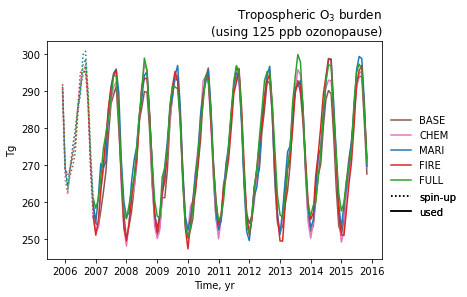

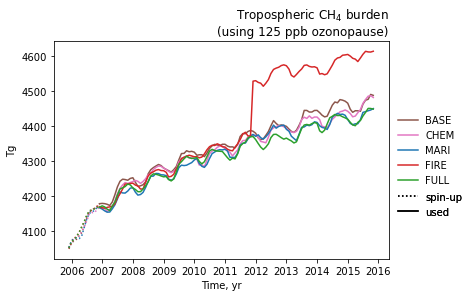

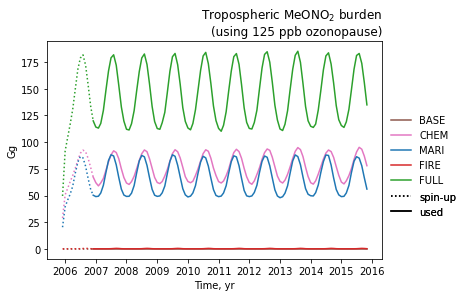

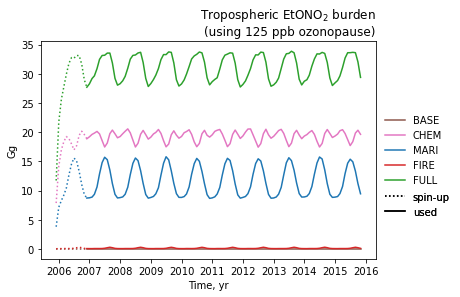

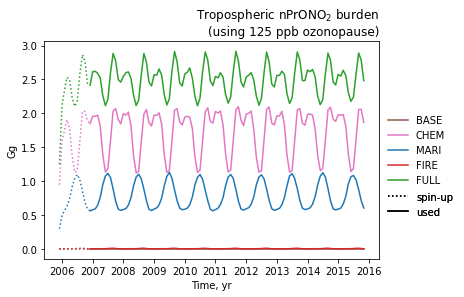

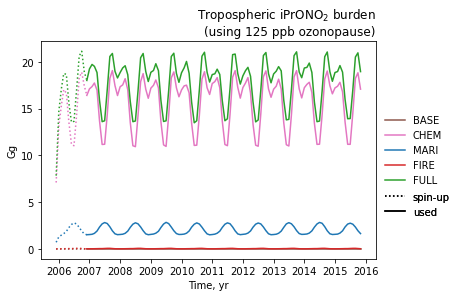

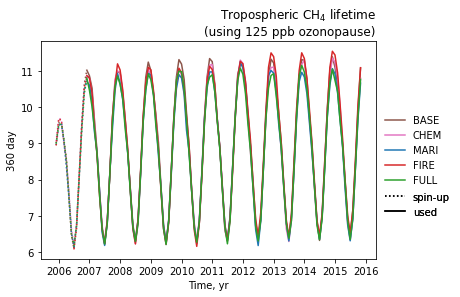

In [16]:
# Plot time series
for varname in MASTER["BASE"].keys():
    fig, ax = plt.subplots()
    for exp in MASTER.keys():
        plt_time_series(MASTER[exp][varname])
    add_custom_legend(ax, exp_plt_kw, frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
    add_custom_legend(ax, leg_plt_kw, frameon=False, loc="center left", bbox_to_anchor=(1, 0.25))

In [17]:
# Add more metrics into a summary table
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    for varname, vardict in TABLE[exp].items():
        # Calculate absolute differences in the annual mean burden and the standard error of the mean
        TABLE[exp][varname]["mean_diff_abs"] = vardict["mean"] - TABLE["BASE"][varname]["mean"]
        TABLE[exp][varname]["sem_err_abs"] = np.sqrt(
            vardict["sem"] ** 2 + TABLE["BASE"][varname]["sem"] ** 2
        )
        # Calculate relative differences in the annual mean burden and the standard error of the mean
        # If BASE's mean is zero or very close to zero, do not calculate relative differences
        if abs(TABLE["BASE"][varname]["mean"]) > 1e-14:
            TABLE[exp][varname]["mean_diff_rel"] = 100 * (
                (TABLE[exp][varname]["mean_diff_abs"]) / TABLE["BASE"][varname]["mean"]
            )
            TABLE[exp][varname]["sem_err_rel"] = 100 * (
                (TABLE[exp][varname]["sem_err_abs"]) / TABLE["BASE"][varname]["mean"]
            )

In [18]:
pd.DataFrame.from_dict(TABLE, orient="index")

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
BASE,"{'units': 'Tg', 'mean': 271.74176, 'std': 1.23...","{'units': 'Tg', 'mean': 4349.913, 'std': 82.05...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'yr', 'mean': 9.04002661227628, 'std...","{'units': '', 'mean': 1.3658970174665435, 'std..."
CHEM,"{'units': 'Tg', 'mean': 273.09576, 'std': 0.65...","{'units': 'Tg', 'mean': 4337.646, 'std': 79.81...","{'units': 'Gg', 'mean': 76.50557, 'std': 0.723...","{'units': 'Gg', 'mean': 19.34826, 'std': 0.058...","{'units': 'Gg', 'mean': 1.740191, 'std': 0.009...","{'units': 'Gg', 'mean': 15.875872, 'std': 0.07...","{'units': 'yr', 'mean': 8.984793650173982, 'st...","{'units': '', 'mean': 1.3542069104517518, 'std..."
MARI,"{'units': 'Tg', 'mean': 274.66797, 'std': 1.34...","{'units': 'Tg', 'mean': 4325.035, 'std': 80.59...","{'units': 'Gg', 'mean': 65.67856, 'std': 0.228...","{'units': 'Gg', 'mean': 11.556798, 'std': 0.03...","{'units': 'Gg', 'mean': 0.7924098, 'std': 0.00...","{'units': 'Gg', 'mean': 2.051754, 'std': 0.007...","{'units': 'yr', 'mean': 8.897582263035055, 'st...","{'units': '', 'mean': 1.3395454112690766, 'std..."
FIRE,"{'units': 'Tg', 'mean': 273.44272, 'std': 1.61...","{'units': 'Tg', 'mean': 4407.642, 'std': 150.7...","{'units': 'Gg', 'mean': 0.20743188, 'std': 0.0...","{'units': 'Gg', 'mean': 0.10992284, 'std': 0.0...","{'units': 'Gg', 'mean': 0.004041156, 'std': 5....","{'units': 'Gg', 'mean': 0.03127816, 'std': 0.0...","{'units': 'yr', 'mean': 9.05717216849625, 'std...","{'units': '', 'mean': 1.3665405320723096, 'std..."
FULL,"{'units': 'Tg', 'mean': 274.9626, 'std': 1.280...","{'units': 'Tg', 'mean': 4323.818, 'std': 74.67...","{'units': 'Gg', 'mean': 144.46078, 'std': 0.64...","{'units': 'Gg', 'mean': 31.112436, 'std': 0.06...","{'units': 'Gg', 'mean': 2.5084631, 'std': 0.00...","{'units': 'Gg', 'mean': 17.925621, 'std': 0.06...","{'units': 'yr', 'mean': 8.894506524121308, 'st...","{'units': '', 'mean': 1.3423123142701217, 'std..."


In [19]:
pd.DataFrame.from_dict(TABLE["BASE"])

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
units,Tg,Tg,Gg,Gg,Gg,Gg,yr,
mean,271.741760,4349.913086,0.0,0.0,0.0,0.0,9.040027,1.365897
std,1.238692,82.052650,0.0,0.0,0.0,0.0,0.082072,0.012475
sem,0.412897,27.350883,0.0,0.0,0.0,0.0,0.027357,0.004158


In [20]:
pd.DataFrame.from_dict(TABLE["FULL"])

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
units,Tg,Tg,Gg,Gg,Gg,Gg,yr,
mean,274.962585,4323.817871,144.460785,31.112436,2.508463,17.925621,8.894507,1.342312
std,1.280141,74.675217,0.643670,0.065980,0.009020,0.069211,0.076283,0.014866
sem,0.426714,24.891739,0.214557,0.021993,0.003007,0.023070,0.025428,0.004955
mean_diff_abs,3.220825,-26.095215,144.460785,31.112436,2.508463,17.925621,-0.145520,-0.023585
sem_err_abs,0.593775,36.982016,0.214557,0.021993,0.003007,0.023070,0.037350,0.006469
mean_diff_rel,1.185252,-0.599902,NaN,NaN,NaN,NaN,-1.609731,-1.726682
sem_err_rel,0.218507,0.850178,NaN,NaN,NaN,NaN,0.413160,0.473592


In [21]:
DISPLAY1 = {}
for exp in EXPERIMENTS.keys():
    DISPLAY1[exp] = {}
    for i in ["o3", "ch4", "tau ch4", "NH/SH OH"]:
        DISPLAY1[exp][i] = f"{TABLE[exp][i]['mean']:1.3f} ({TABLE[exp][i]['sem']:1.3f})"
pd.DataFrame.from_dict(DISPLAY1, orient="index")

,o3,ch4,tau ch4,NH/SH OH
BASE,271.742 (0.413),4349.913 (27.351),9.040 (0.027),1.366 (0.004)
CHEM,273.096 (0.217),4337.646 (26.606),8.985 (0.027),1.354 (0.004)
MARI,274.668 (0.449),4325.035 (26.865),8.898 (0.028),1.340 (0.004)
FIRE,273.443 (0.540),4407.642 (50.253),9.057 (0.052),1.367 (0.005)
FULL,274.963 (0.427),4323.818 (24.892),8.895 (0.025),1.342 (0.005)


In [22]:
DISPLAY2 = {}
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    DISPLAY2[exp] = {}
    for i in ["meono2", "etono2", "nprono2", "iprono2"]:
        DISPLAY2[exp][i] = f"{TABLE[exp][i]['mean']:1.3f} ({TABLE[exp][i]['sem']:1.3f})"
pd.DataFrame.from_dict(DISPLAY2, orient="index")

,meono2,etono2,nprono2,iprono2
CHEM,76.506 (0.241),19.348 (0.019),1.740 (0.003),15.876 (0.024)
MARI,65.679 (0.076),11.557 (0.013),0.792 (0.001),2.052 (0.002)
FIRE,0.207 (0.001),0.110 (0.000),0.004 (0.000),0.031 (0.000)
FULL,144.461 (0.215),31.112 (0.022),2.508 (0.003),17.926 (0.023)


In [23]:
DISPLAY3 = {}
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    DISPLAY3[exp] = {}
    for i in ["o3", "tau ch4"]:
        DISPLAY3[exp][
            i
        ] = f"{TABLE[exp][i]['mean_diff_rel']:1.2f} ({TABLE[exp][i]['sem_err_rel']:1.2f})"
pd.DataFrame.from_dict(DISPLAY3, orient="index")

,o3,tau ch4
CHEM,0.50 (0.17),-0.61 (0.42)
MARI,1.08 (0.22),-1.58 (0.43)
FIRE,0.63 (0.25),0.19 (0.65)
FULL,1.19 (0.22),-1.61 (0.41)


In [24]:
pd.DataFrame.from_dict(DISPLAY3, orient="index").to_latex()

'\\begin{tabular}{lll}\n\\toprule\n{} &           o3 &       tau ch4 \\\\\n\\midrule\nCHEM &  0.50 (0.17) &  -0.61 (0.42) \\\\\nMARI &  1.08 (0.22) &  -1.58 (0.43) \\\\\nFIRE &  0.63 (0.25) &   0.19 (0.65) \\\\\nFULL &  1.19 (0.22) &  -1.61 (0.41) \\\\\n\\bottomrule\n\\end{tabular}\n'